# **Initialization commands, inclusion of libraries and loading of dataset**

In [0]:
import os
from tqdm import tqdm
import tensorflow as tf
import cv2
#import numpy as np
import scipy
from tensorflow.keras import datasets,models,layers
import tflearn
#from tflearn.layers.conv import conv_2d,max_pool_2d
#from tflearn.layers.core import input_data,dropout,fully_connected
#from tflearn.layers.estimator import regression

!pip install numpy==1.16.2
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

#dataset = !wget https://ivrl.epfl.ch/wp-content/uploads/2018/08/nirscene0.zip
#!ls







     |████████████████████████████████| 17.3MB 136kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.4
    Uninstalling numpy-1.17.4:
      Successfully uninstalled numpy-1.17.4


#**Creating of the pyramid levels**

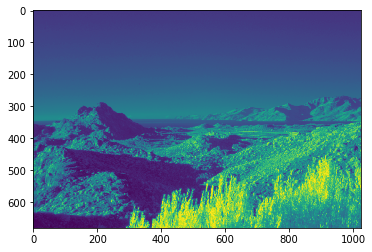

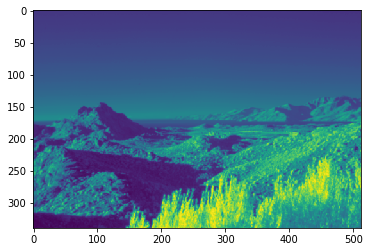

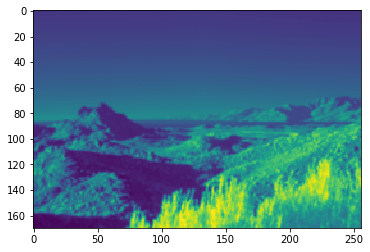

In [0]:
import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import sklearn.preprocessing as prp

#%matplotlib inline
testim = mpimg.imread('/content/drive/My Drive/nirscene1_1gb/country/0002_nir.tiff')

img_lev1 = cv2.pyrDown(testim)
img_lev2 = cv2.pyrDown(img_lev1)

plt.figure(1)
imshow(testim)
plt.figure(2)
imshow(img_lev1)
plt.figure(3)
imshow(img_lev2)



# **Scale images to zero mean and unit variance**

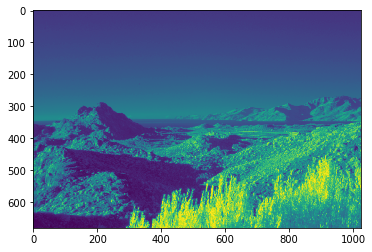

In [0]:
from sklearn import preprocessing as prp


img_test = mpimg.imread('/content/drive/My Drive/nirscene1_1gb/country/0002_nir.tiff')
img_scal = prp.scale(img_test)
img_padded = cv2.copyMakeBorder(img_test,1,1,1,1,cv2.BORDER_REPLICATE)


i = 1
j = 1



#imshow(img_padded[i-1:i+2,j-1:j+2])

#plt.figure(1)
#plt.title('Original')
imshow(img_test)


#plt.figure(2)
#plt.title('Scaled')
#imshow(img_scal)

# **Rough work --> delete later**

In [0]:
from scipy.stats import norm

def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h



def local_normalize(im,sigma1,sigma2):
    epsilon = 1e-1
    halfsize1 = np.ceil(-norm.ppf(epsilon/2,0,sigma1))
    size1 = 2*halfsize1 + 1
    halfsize2 = np.ceil(-norm.ppf(epsilon/2,0,sigma2))
    size2 = 2*halfsize2 + 1

    gaussian1 = matlab_style_gauss2D(shape = (size1,size1),sigma=sigma1)
    gaussian2 = matlab_style_gauss2D(shape=(size2,size2),sigma=sigma2)
    num = im - scipy.ndimage.correlate(im, gaussian1, mode='nearest')
    den = np.sqrt(scipy.ndimage.correlate(np.square(num), gaussian2, mode='nearest'))

    return (num / den)

In [0]:
img_test = np.double(img_test)
out = np.zeros(img_test.shape, np.double)
normalized = cv2.normalize(img_test, out, 1.0, 0.0, cv2.NORM_MINMAX)

for i in range(1,15):
  plt.figure(i)
  imshow(local_normalize(normalized,i,i))

Output hidden; open in https://colab.research.google.com to view.

#**Preprocessing_not to be used --> delete later**

In [0]:
img_padded = cv2.copyMakeBorder(img_test,1,1,1,1,cv2.BORDER_REPLICATE)

m1,n1 = img_padded.shape
m,n = img_test.shape

img_por = np.zeros((m,n))

q = np.max(img_test)

for i in range (1,m1-1):
  for j in range (1,n1-1):
    y = [img_padded[i-1,j-1],img_padded[i-1,j],img_padded[i-1,j+1],img_padded[i,j-1],img_padded[i,j],img_padded[i,j+1],img_padded[i+1,j-1],img_padded[i+1,j],img_padded[i+1,j+1]]
    mean_y = np.mean(y)
    var_y = np.var(y)
    std_dev = np.sqrt(var_y)
    if(std_dev == 0):
      img_por[i-1,j-1] = q
    else:
      img_por[i-1,j-1] = (img_padded[i,j] - mean_y)/std_dev

imshow(img_por)


#**Preprocessing** **byproducts** **(calculating mean and variance images)**

In [0]:
#image = cv2.copyMakeBorder( src, top, bottom, left, right, borderType)
img_padded = cv2.copyMakeBorder(img_test,1,1,1,1,cv2.BORDER_REPLICATE)

In [0]:
m_ori,n_ori = img_test.shape
m,n = img_padded.shape

mean_im1g = np.zeros((m_ori,n_ori))
var_im1g  = np.zeros((m_ori,n_ori))

x=[]
for i in range(1,m-1):
  for j in range(1,n-1):
    y = [img_padded[i-1,j-1],img_padded[i-1,j],img_padded[i-1,j+1],img_padded[i,j-1],img_padded[i,j],img_padded[i,j+1],img_padded[i+1,j-1],img_padded[i+1,j],img_padded[i+1,j+1]]

    mean_y = np.mean(y)
    var_y = np.var(y)

    mean_im1g[i-1,j-1] = mean_y
    var_im1g[i-1,j-1] = var_y  

#print(img_test[0,0])
#mean_im1g[0,0]  = [124,40] 

Text(0.5, 1.0, 'Processed image')

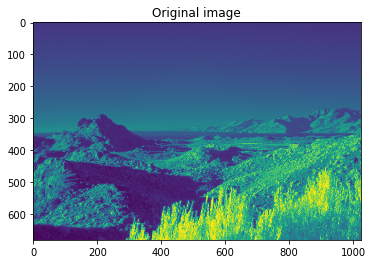

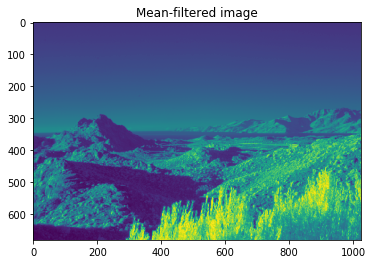

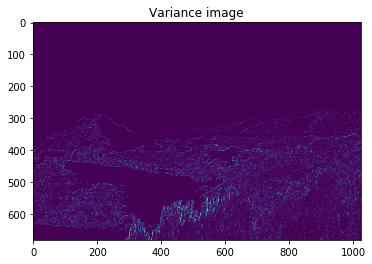

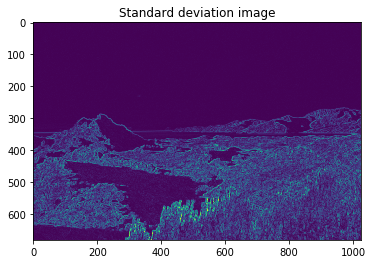

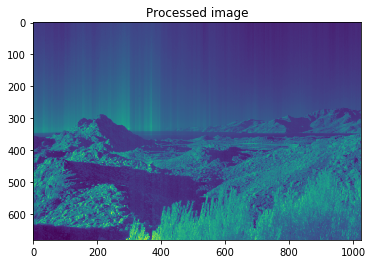

In [0]:

std_devim1g = np.sqrt(var_im1g)

plt.figure(1)
plt.title("Original image")
imshow(img_test)

plt.figure(2)
plt.title("Mean-filtered image")
imshow(mean_im1g)

plt.figure(3)
plt.title("Variance image")
imshow(var_im1g)

plt.figure(4)
plt.title("Standard deviation image")
imshow(std_devim1g)

plt.figure(5)
processed_img = prp.scale(img_test)
imshow(processed_img)
plt.title("Processed image") 


In [0]:
print(mean_im1g.shape)
print("lol")
print(img_test)

# **Preprocess all images in the dataset**

In [0]:
import glob

TRAIN_COUNTRY = '/content/drive/My Drive/nirscene1_1gb/country'
TRAIN_FIELD = '/content/drive/My Drive/nirscene1_1gb/field'
TRAIN_FOREST = '/content/drive/My Drive/nirscene1_1gb/forest'
TRAIN_INDOOR = '/content/drive/My Drive/nirscene1_1gb/indoor'
TRAIN_MOUNTAIN = '/content/drive/My Drive/nirscene1_1gb/mountain'
TRAIN_OLDBUILDING = '/content/drive/My Drive/nirscene1_1gb/oldbuilding'


country_img = glob.glob(TRAIN_COUNTRY + '/*.tiff')
field_img = glob.glob(TRAIN_FIELD + '/*.tiff')
forest_img = glob.glob(TRAIN_FOREST + '/*.tiff')
indoor_img = glob.glob(TRAIN_INDOOR + '/*.tiff')
mountain_img = glob.glob(TRAIN_MOUNTAIN + '/*.tiff')
oldbuilding_img = glob.glob(TRAIN_OLDBUILDING + '/*.tiff')


country_img_sorted = sorted(country_img)
field_img_sorted = sorted(field_img)
forest_img_sorted = sorted(forest_img)
indoor_img_sorted = sorted(indoor_img)
mountain_img_sorted = sorted(mountain_img)
oldbuilding_img_sorted = sorted(oldbuilding_img)


In [0]:
#import numpy as np
i = 0
L1 = []
L2 = []
L4 = []
while(i <= 104):
  scale_percent = 50
  x = mpimg.imread(country_img_sorted[i])
  width = int(x.shape[1] * scale_percent / 100)
  height = int(x.shape[0] * scale_percent / 100)
  if(x.shape[1] <= 1000 and x.shape[0] <= 750):
    i += 2

    print(x.shape)
  else:
    name1 = '/content/drive/My Drive/nirscene1_1gb/Trial images/country_img_L1_' + str(i) + '.tiff'
    name2 = '/content/drive/My Drive/nirscene1_1gb/Trial images/country_img_L2_' + str(i) + '.tiff'
    name4 = '/content/drive/My Drive/nirscene1_1gb/Trial images/country_img_L4_' + str(i) + '.tiff'
    x1 = x[0:678,0:1024] 
    dim = (width, height)    
    y = cv2.resize(x1,dim,interpolation=cv2.INTER_AREA)
    z = prp.scale(y)
    z2 = z[0:339,0:512]
    z2_1levelup = cv2.pyrDown(z2)
    z2_2levelup = cv2.pyrDown(z2_1levelup) 
    
    min_max_scaler = prp.MinMaxScaler()
    imgg = min_max_scaler.fit_transform(z2)
    imgg1 = min_max_scaler.fit_transform(z2_1levelup)
    imgg2 = min_max_scaler.fit_transform(z2_2levelup)

    #plt.figure(i)
    #imshow(imgg)
    #np.save('xyz.npy',z2)
    #cv2.imwrite(name1,imgg)
    #cv2.imwrite(name2,imgg1)
    #cv2.imwrite(name4,imgg2)
    
    L1.append(imgg) 

    print(imgg.shape)
    #print(L1.shape)
    #break
    i += 2

plt.figure(1)
imshow(L1[0])
x = np.array(L1)

print(x.shape)
np.save("preprocessed_L1.npy",L1)

    

NameError: ignored

In [0]:
6# save np.load

x = np.load('preprocessed_L1.npy')
print(x.shape)
#plt.figure(1)
#imshow(x[0])

(52,)


In [0]:
i = 1
L1_ne = []

while(i < 104):
  scale_percent = 50
  x = mpimg.imread(country_img_sorted[i])
  width = int(x.shape[1] * scale_percent / 100)
  height = int(x.shape[0] * scale_percent / 100)
  if(x.shape[1] <= 1000):
    i += 2
  else:
    x1 = x[0:678,0:1024] 
    dim = (width, height)    
    y = cv2.resize(x1,dim,interpolation=cv2.INTER_AREA)
   
    z2 = y[0:339,0:512]
  

    z4 = z2/255   #L1.append(imgg)
    #plt.figure(i)
    #print(z2.shape)
    #imshow(z2)
    #break
    L1_ne.append(z4)
    i += 2
#display(z4)
rho = np.array(L1_ne)
np.save("preprocessed_targets.npy",rho)


In [0]:

#d = mpimg.imread('/content/drive/My Drive/nirscene1_1gb/Trial images/country_img_L1_2.tiff')
#imshow(d)

a= np.load('preprocessed_targets.npy')
print(a.shape)

print(a[0])

(50,)
[[[0.91764706 0.90196078 0.98431373]
  [0.91764706 0.90588235 0.98039216]
  [0.91764706 0.90196078 0.98431373]
  ...
  [1.         0.97647059 1.        ]
  [1.         0.98431373 1.        ]
  [1.         0.98039216 1.        ]]

 [[0.91764706 0.90980392 0.98431373]
  [0.92156863 0.90980392 0.98431373]
  [0.9254902  0.90196078 0.98823529]
  ...
  [0.98823529 0.96078431 1.        ]
  [1.         0.97647059 1.        ]
  [1.         0.98039216 1.        ]]

 [[0.92156863 0.90196078 0.98823529]
  [0.92156863 0.90196078 0.98431373]
  [0.91764706 0.90588235 0.98823529]
  ...
  [0.97647059 0.94509804 1.        ]
  [0.99607843 0.96470588 1.        ]
  [1.         0.97254902 1.        ]]

 ...

 [[0.29411765 0.22745098 0.19607843]
  [0.28235294 0.22352941 0.19607843]
  [0.34509804 0.25098039 0.20784314]
  ...
  [0.59215686 0.54509804 0.54509804]
  [0.58039216 0.5372549  0.52941176]
  [0.59215686 0.54901961 0.5372549 ]]

 [[0.51372549 0.38431373 0.32156863]
  [0.38431373 0.27058824 0.2156

In [0]:
print(a[0].shape)

(339, 512, 3)



# CNN ----ASB



In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Activation ,Flatten , Conv1D ,MaxPooling2D,Conv2D,MaxPooling1D
from keras.utils import plot_model
from keras.engine import InputLayer

#data
bw_data     =  np.load('preprocessed_L1.npy')              ## b/w image
col_data    =  np.load('preprocessed_targets.npy')   ##color images 


img_cols = 512
img_rows = 339

# bw_data = bw_data.reshape(bw_data.shape[0], img_cols, img_rows, 1)
# col_data =  col_data[0].reshape()   ##color images 

print("The input data array is shaped:" + str(bw_data.shape))
print("The target data array is shaped:" + str(col_data.shape))

ip_shape=(img_cols, img_rows, 1)

model = tf.keras.models.Sequential()
# model.add()
#keras.layers.Conv1D(filters_size,kernel_size,padding = 'same')

#model.add(InputLayer(input_shape=(339, 512, 1)))
#model.add(Input((339,512,1)))
# first convolutional block nf1 = 16 nk = 3x3 

model.add(  Conv1D( 16, kernel_size=3 ,input_shape=bw_data.shape[1:],padding = 'same' ))   # add input_shape = X.shape()
model.add(  Conv1D( 16, kernel_size=3 ,padding = 'same' ))   # add input_shape = X.shape()
model.add(  Conv1D( 16, kernel_size=3 ,padding = 'same' ))   # add input_shape = X.shape()
model.add( Activation("relu") )

# #first pooling layer   size = 2x2
model.add( MaxPooling1D(pool_size=1  ))

#print(ip_shape)

#second convolutional block nf2 = 32,nk= 3x3
model.add(  Conv1D( 32, kernel_size=3 ,padding = 'same'))
model.add(  Conv1D( 32, kernel_size=3 ,padding = 'same'))
model.add(  Conv1D( 32, kernel_size=3 ,padding = 'same'))
model.add( Activation("relu") )


#second pooling layer   size = 2x2
model.add( MaxPooling1D(pool_size=1)  )

#third and final convolutional block nf3= 64,nk = 3x3
model.add(  Conv1D( 64, kernel_size=3 ,padding = 'same'))
model.add(  Conv1D( 64, kernel_size=3 ,padding = 'same'))
model.add(  Conv1D( 64, kernel_size=3 ,padding = 'same'))
model.add( Activation("relu") ) 

# #fully connected layer
print(model.output_shape)
#model.add(Flatten())
print(model.input_shape)



model.add( Dense(512, activation='relu') )
#model.add( Dense(3, activation='relu') )
#model.add(Dense(1, input_shape = (339,512,3), activation='relu'))
#model.add(Dense(3,  activation='relu' ))
print(model.summary())

# # train!!
model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.SGD(lr=0.01),metrics=['accuracy'])
#model.fit(x = bw_data, y = col_data , epochs = 1 , verbose = 2 , validation_split = 0) 

Using TensorFlow backend.


FileNotFoundError: ignored

In [0]:
###### this is 2d
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Activation ,Flatten , Conv1D ,MaxPooling2D,Conv2D,MaxPooling1D
from keras.utils import plot_model
from keras.engine import InputLayer

#data
bw_data     =  np.load('preprocessed_L1.npy')              ## b/w image
col_data    =  np.load('preprocessed_targets.npy')   ##color images 


img_cols = 512
img_rows = 339

#bw_data = bw_data.reshape(50, img_rows , img_cols, 1)
# col_data =  col_data[0].reshape()   ##color images 

print("The input data array is shaped:" + str(bw_data.shape))
print("The target data array is shaped:" + str(col_data.shape))

ip_shape=(img_cols, img_rows, 1)

model = tf.keras.models.Sequential()
# model.add()
#keras.layers.Conv1D(filters_size,kernel_size,padding = 'same')

#model.add(InputLayer(input_shape=(339, 512, 1)))
#model.add(Input((339,512,1)))
# first convolutional block nf1 = 16 nk = 3x3 

model.add(  Conv2D( 16, kernel_size=(3,3) ,input_shape=(339,512,1),padding = 'same' ))   # add input_shape = X.shape()
model.add(  Conv2D( 16, kernel_size=(3,3) ,padding = 'same' ))   # add input_shape = X.shape()
model.add(  Conv2D( 16, kernel_size=(3,3) ,padding = 'same' ))   # add input_shape = X.shape()
model.add( Activation("relu") )

# #first pooling layer   size = 2x2
model.add( MaxPooling2D(pool_size=(2,2) ,padding = 'same'))

#print(ip_shape)

#second convolutional block nf2 = 32,nk= 3x3
model.add(  Conv2D( 32, kernel_size=(3,3),padding = 'same'))
model.add(  Conv2D( 32, kernel_size=(3,3),padding = 'same'))
model.add(  Conv2D( 32, kernel_size=(3,3) ,padding = 'same'))
model.add( Activation("relu") )


#second pooling layer   size = 2x2
model.add( MaxPooling2D(pool_size=(2,2),padding = 'same') )

#third and final convolutional block nf3= 64,nk = 3x3
model.add(  Conv2D( 64, kernel_size=(3,3) ,padding = 'same'))
model.add(  Conv2D( 64, kernel_size=(3,3) ,padding = 'same'))
model.add(  Conv2D( 64, kernel_size=(3,3) ,padding = 'same'))
model.add( Activation("relu") ) 

# #fully connected layer
print(model.output_shape)
#model.add(Flatten())
print(model.input_shape)



model.add( Dense(3, activation='relu') )
#model.add( Dense(3, activation='relu') )
#model.add(Dense(1, input_shape = (339,512,3), activation='relu'))
#model.add(Dense(3,  activation='relu' ))
print(model.summary())

# # train!!
model.compile(loss=tf.keras.losses.mean_squared_error,optimizer=tf.keras.optimizers.RMSprop(lr=0.0035),metrics=['accuracy'])
#model.fit(x = bw_data, y = col_data , epochs = 2 , verbose = 2 , validation_split = 0) 

The input data array is shaped:(52,)
The target data array is shaped:(50,)
(None, 85, 128, 64)
(None, 339, 512, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 339, 512, 16)      160       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 339, 512, 16)      2320      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 339, 512, 16)      2320      
_________________________________________________________________
activation_6 (Activation)    (None, 339, 512, 16)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 170, 256, 16)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 170, 256, 32)      4640      
_____

In [0]:
z = model.predict(bw_data,verbose=2)
print(z)

10/10 - 9s
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


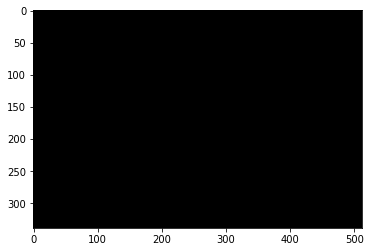

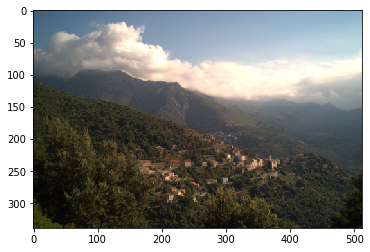

In [0]:
q = (z)/(np.max(z)-(np.min(z)))
#print(q)

plt.figure(1)
imshow(q[5])

##plt.figure(2)
#imshow(cv2.resize(bw_data[)

plt.figure(3)
imshow(col_data[5])

In [0]:
from keras.engine import InputLayer
from keras.layers import Conv1D, UpSampling2D
from keras.models import Sequential

#from colorization.fusion_layer import FusionLayer


class Colorization:
    def __init__(self, depth_after_fusion):
        self.encoder = _build_encoder()
        self.fusion = FusionLayer()
        self.after_fusion = Conv1D(
            depth_after_fusion, (1, 1), activation='relu')
        self.decoder = _build_decoder(depth_after_fusion)

    def build(self, img_l, img_emb):
        img_enc = self.encoder(img_l)

        fusion = self.fusion([img_enc, img_emb])
        fusion = self.after_fusion(fusion)

        return self.decoder(fusion)


def _build_encoder():
    model = Sequential(name='encoder')
    model.add(InputLayer(input_shape=(None, None, 1)))
    model.add(Conv1D(64, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv1D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv1D(128, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv1D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv1D(256, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv1D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv1D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv1D(256, (3, 3), activation='relu', padding='same'))
    return model


def _build_decoder(encoding_depth):
    model = Sequential(name='decoder')
    model.add(InputLayer(input_shape=(None, None, encoding_depth)))
    model.add(Conv1D(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv1D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv1D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv1D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv1D(2, (3, 3), activation='tanh', padding='same'))
    model.add(UpSampling2D((2, 2)))
    return model